In [1]:
#All Required Libraries
import os
import time
import math
import csv
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib.cm as cm
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint #Otherwise only "odeint_adjoint"

In [2]:
#Configuration
method = 'rk4' #RK-45
data_size = 600
batch_time = 10
batch_size = 20
niters = 1500
test_freq = 20
viz = True
gpu = 0
#device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')
device = 'cpu'

In [3]:
#Define ODE System
omega0 = torch.tensor(2*60*np.pi)
delta1star = -0.117919635325941
omega1star = 0
delta2star = 0.094729837775605
omega2star = 0
v1star = torch.tensor(2.0)
v2star = torch.tensor(2.0)
x0 = torch.tensor([[delta1star + np.pi/6], [omega1star], [delta2star], [omega2star]]).to(device)
t = torch.arange(0.,20., 1/30).to(device)

M1 = torch.tensor(100)
D1 = torch.tensor(10)
X1 = torch.tensor(0.963)
M2 = torch.tensor(12)
D2 = torch.tensor(10)
X2 = torch.tensor(0.667)
Bred = torch.tensor(-0.583070554936976)
Gred = torch.tensor(-0.003399828308670)
Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


class Real(nn.Module):
    def forward(self,t,x):
        dxdt = torch.zeros_like(x)
        dxdt[0] = x[1]
        dxdt[1] = (-D1*x[1]/omega0 + v1star*v2star*Bred*torch.sin(x[0]-x[2]) - v1star*v2star*Gred*torch.cos(x[0]-x[2]) + Pmech1star)*omega0/M1
        dxdt[2] = x[3]
        dxdt[3] = (-D2*x[3]/omega0 + v1star*v2star*Bred*torch.sin(x[2]-x[0]) - v1star*v2star*Gred*torch.cos(x[2]-x[0]) + Pmech2star)*omega0/M2
        self.dxdt = dxdt
        return dxdt

real_dynamics = Real()  
  
with torch.no_grad():
    true_x = odeint(real_dynamics, x0, t, method = method)

true_omega1 = true_x[:,1,0] / omega0
true_omega2 = true_x[:,3,0] / omega0

C:\Users\LEGION\AppData\Local\Temp\ipykernel_31916\1785091874.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pmech1star = torch.tensor(-v1star*v2star*Bred*np.sin(delta1star - delta2star) + v1star*v2star*Gred*np.cos(delta1star-delta2star))
C:\Users\LEGION\AppData\Local\Temp\ipykernel_31916\1785091874.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Pmech2star = torch.tensor(-v1star*v2star*Bred*np.sin(delta2star - delta1star) + v1star*v2star*Gred*np.cos(delta2star-delta1star))


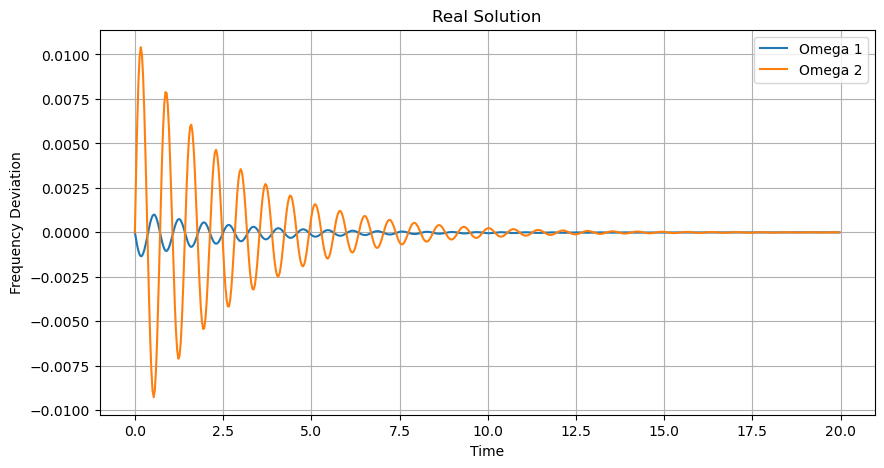

In [4]:
#Plot Correct Data
plt.figure(figsize=(10, 5))
plt.plot(t.cpu().numpy(), true_omega1.cpu().numpy(), label='Omega 1')
plt.plot(t.cpu().numpy(), true_omega2.cpu().numpy(), label='Omega 2')
plt.xlabel('Time')
plt.ylabel('Frequency Deviation')
plt.title('Real Solution')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
#Define Mini-Batches
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return s.to(device), batch_x0.to(device), batch_t.to(device), batch_x.to(device)

In [5]:
#Visualization

def visualize(true_x, pred_x, odefunc, itr, save_path):
    if viz:
        fig, ((x_delta1, x_delta2), (x_omega1, x_omega2)) = plt.subplots(2, 2, figsize=(12, 8), facecolor='white')

        x_delta1.set_title('Generator 1')
        x_delta1.set_xlabel('Time [s]')
        x_delta1.set_ylabel('Rotor Angle')
        x_delta1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,0,0] / omega0, 'g-', label='True Delta 1')
        x_delta1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,0,0] / omega0, 'b--', label='Predicted Delta 1')
        x_delta1.legend()

        x_delta2.set_title('Generator 2')
        x_delta2.set_xlabel('Time [s]')
        x_delta2.set_ylabel('Rotor Angle')
        x_delta2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,2,0] / omega0, 'g-', label='True Delta 2')
        x_delta2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,2,0] / omega0, 'b--', label='Predicted Delta 2')
        x_delta2.legend()

        x_omega1.set_title('Generator 1')
        x_omega1.set_xlabel('Time [s]')
        x_omega1.set_ylabel('Frequency Deviation')
        x_omega1.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,1,0] / omega0, 'g-', label='True Omega 1')
        x_omega1.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,1,0] / omega0, 'b--', label='Predicted Omega 1')
        x_omega1.legend()

        x_omega2.set_title('Generator 2')
        x_omega2.set_xlabel('Time [s]')
        x_omega2.set_ylabel('Frequency Deviation')
        x_omega2.plot(t.cpu().numpy(), true_x.cpu().numpy()[:,3,0] / omega0, 'g-', label='True Omega 2')
        x_omega2.plot(t.cpu().numpy(), pred_x.cpu().numpy()[:,3,0] / omega0, 'b--', label='Predicted Omega 2')
        x_omega2.legend()
        
        plt.tight_layout()
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path)
        plt.show()
        plt.close(fig)

"""         ax_vecfield.set_title('Learned Vector Field')
        ax_vecfield.set_xlabel('x')
        ax_vecfield.set_ylabel('y')

        y, x = np.mgrid[-2:2:21j, -2:2:21j]
        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()
        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)
        dydt = (dydt / mag).reshape(21, 21, 2)

        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")""""Ejemplo 1.ipynb"

'         ax_vecfield.set_title(\'Learned Vector Field\')\n        ax_vecfield.set_xlabel(\'x\')\n        ax_vecfield.set_ylabel(\'y\')\n\n        y, x = np.mgrid[-2:2:21j, -2:2:21j]\n        dydt = odefunc(0, torch.Tensor(np.stack([x, y], -1).reshape(21 * 21, 2)).to(device)).cpu().detach().numpy()\n        mag = np.sqrt(dydt[:, 0]**2 + dydt[:, 1]**2).reshape(-1, 1)\n        dydt = (dydt / mag).reshape(21, 21, 2)\n\n        ax_vecfield.streamplot(x, y, dydt[:, :, 0], dydt[:, :, 1], color="black")Ejemplo 1.ipynb'

In [6]:
#NN to learn the ODE

class NeuralODE(nn.Module):
    def __init__(self, M1, D1, M2, D2, V1, V2, B, G, Pmech1, Pmech2):
        super(NeuralODE, self).__init__()
        self.M1 = M1
        self.M2 = nn.Parameter(M2)
        self.D1 = D1
        self.D2 = nn.Parameter(D2)
        self.V1 = V1
        self.V2 = V2
        #self.V2 = nn.Parameter(V2)
        self.B = B
        #self.B = nn.Parameter(B)
        self.G = G
        #self.G = nn.Parameter(G)
        self.Pmech1 = Pmech1
        self.Pmech2 = Pmech2
        #self.Pmech2 = nn.Parameter(Pmech2)
        
    def forward(self, t, y):
        dydt = torch.zeros_like(y)
        dydt[0] = y[1]
        dydt[1] = (-self.D1*y[1]/omega0 + self.V1*self.V2*self.B*torch.sin(y[0]-y[2]) - self.V1*self.V2*self.G*torch.cos(y[0]-y[2]) + self.Pmech1)*omega0/self.M1
        dydt[2] = y[3]
        dydt[3] = (-self.D2*y[3]/omega0 + self.V1*self.V2*self.B*torch.sin(y[2]-y[0]) - self.V1*self.V2*self.G*torch.cos(y[2]-y[0]) + self.Pmech2)*omega0/self.M2
        self.dydt = dydt
        return dydt

In [ ]:
#DEBUGGING ZONE

Delta = 1.000001 #Porcentual deviation from real value
TargetPercent = 1
M1_G = M1
D1_G = D1
M2_G = Delta*M2
D2_G = Delta*D2
V1_G = v1star
V2_G = v2star
B_G = Bred
G_G = Gred
Pmech1_G = Pmech1star
Pmech2_G = Pmech2star

def percent_deviation(current_value, target_value):
     return abs(current_value - target_value) / target_value * 100


print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"Bred: {Bred.item()}", f"B_G: {B_G.item()}")
print(f"Gred: {Gred.item()}", f"G_G: {G_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]
    batch_t = t[:batch_time]
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)
    return s.to(device), batch_x0.to(device), batch_t.to(device), batch_x.to(device)


func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)
optimizer = torch.optim.RMSprop(func.parameters(), lr = 0.001) #RMSprop
end = time.time()
ii = 0

s, batch_x0, batch_t, batch_x = get_batch()

with torch.no_grad():
     for batches in range(0,batch_size):
          pred_x = odeint(func, batch_x0[batches], batch_t, method=method).to(device)
          print(batches+1)
     
#visualize(batch_x, pred_x, func, 0)     

In [ ]:
#DEBUG PRINT
print(batch_x.size())
print(pred_x.size())

print(pred_x[0,0:2,0])
print(batch_x[0,4,0:2,0])
print(pred_x[0,0:2,0] - batch_x[0,4,0:2,0])



M1: 100 M1_G: 100
D1: 10 D1_G: 10
M2: 12 M2_G: 12.59999942779541
D2: 10 D2_G: 10.5
V1: 2.0 V1_G: 2.0
V2: 2.0 V2_G: 2.0
Bred: -0.5830705761909485 B_G: -0.5830705761909485
Gred: -0.003399828216060996 G_G: -0.003399828216060996
Pmech1: -0.5055221915245056 Pmech1_G: -0.5055221915245056
Pmech2: 0.47893619537353516 Pmech2_G: 0.47893619537353516
Initial Parameters:
M2: 12.59999942779541
D2: 10.5


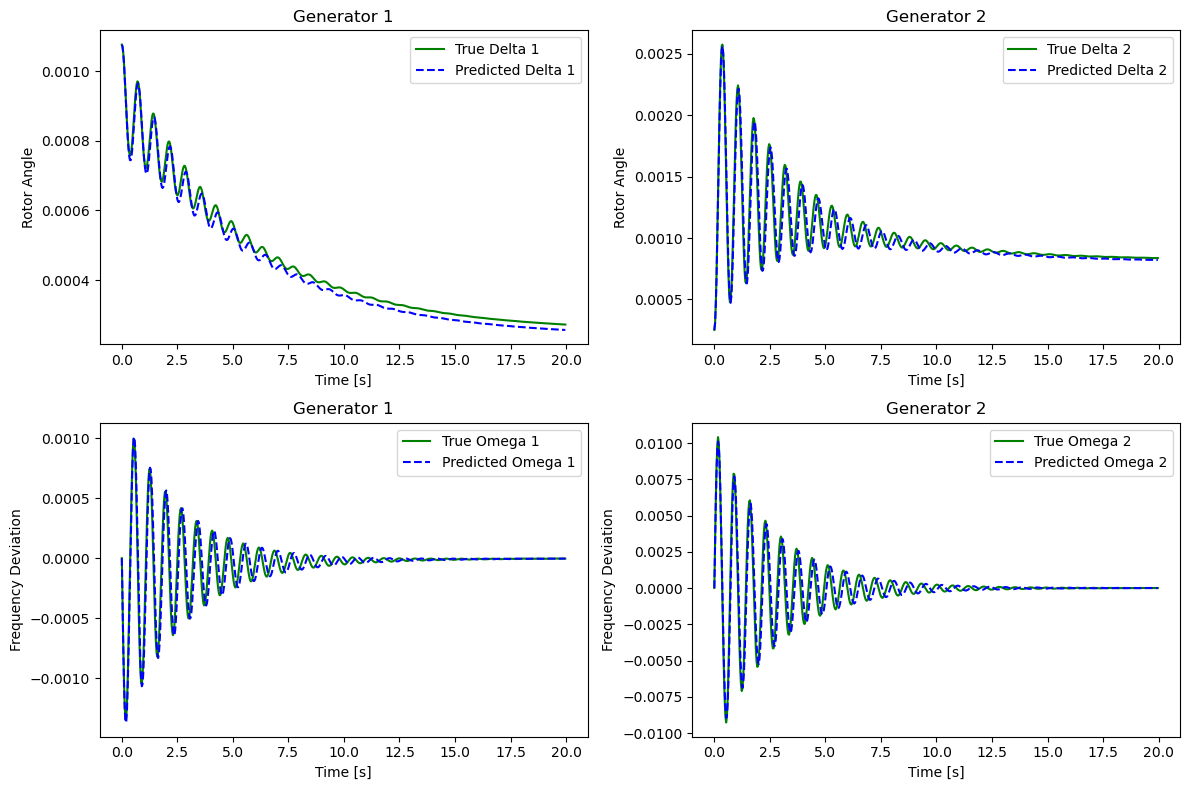


Iteration 0 | Total Loss 0.00040208813152275980
Updated Parameters:
M2: 12.503297805786133
D2: 10.573256492614746


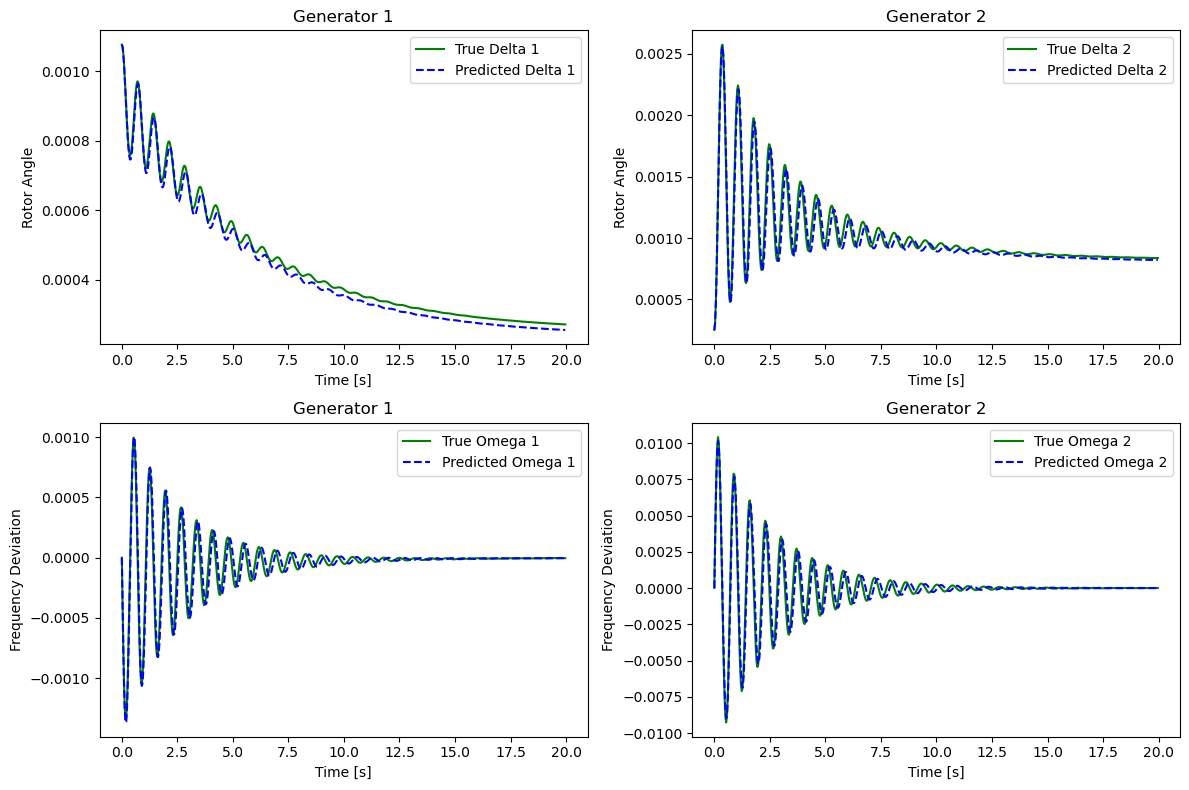

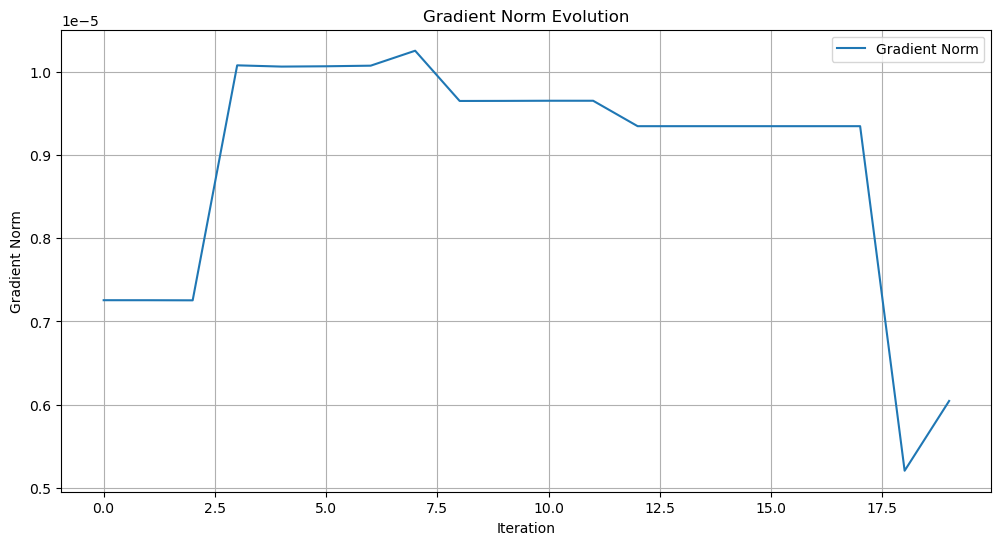


Iteration 20 | Total Loss 0.00006425627361750230
Updated Parameters:
M2: 12.184089660644531
D2: 10.470114707946777


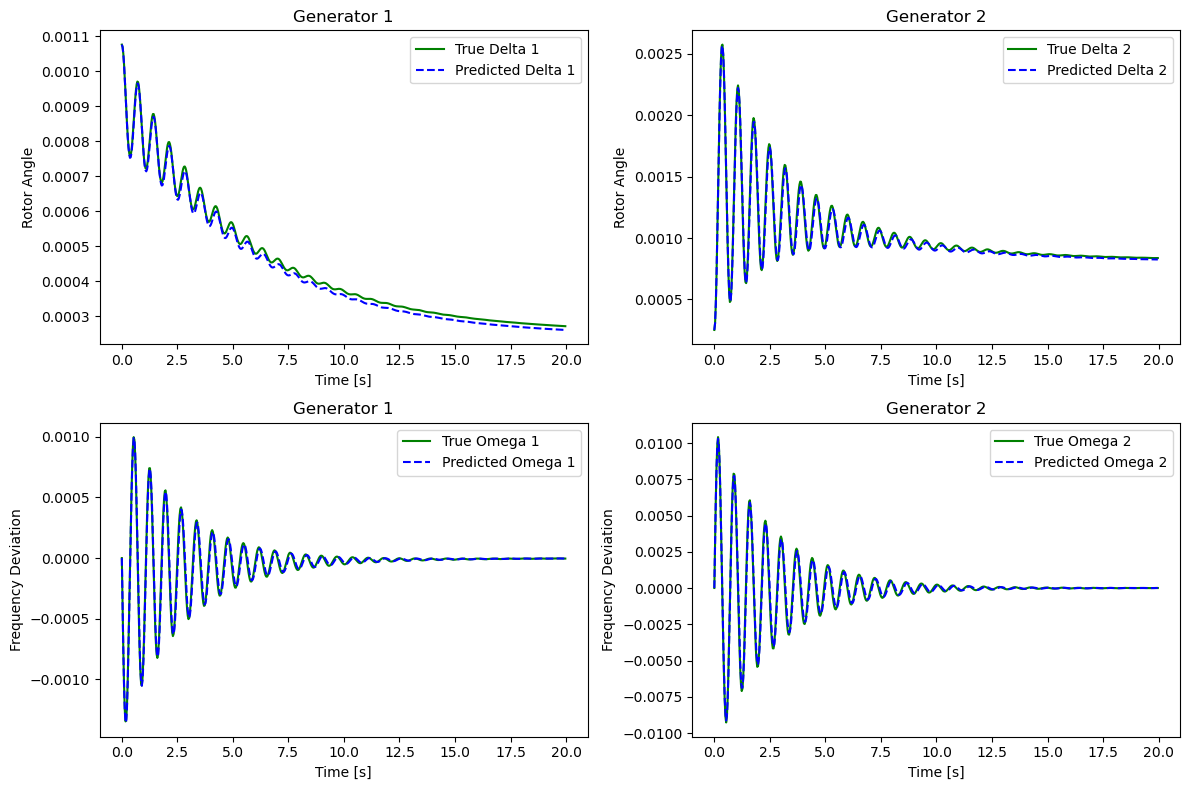

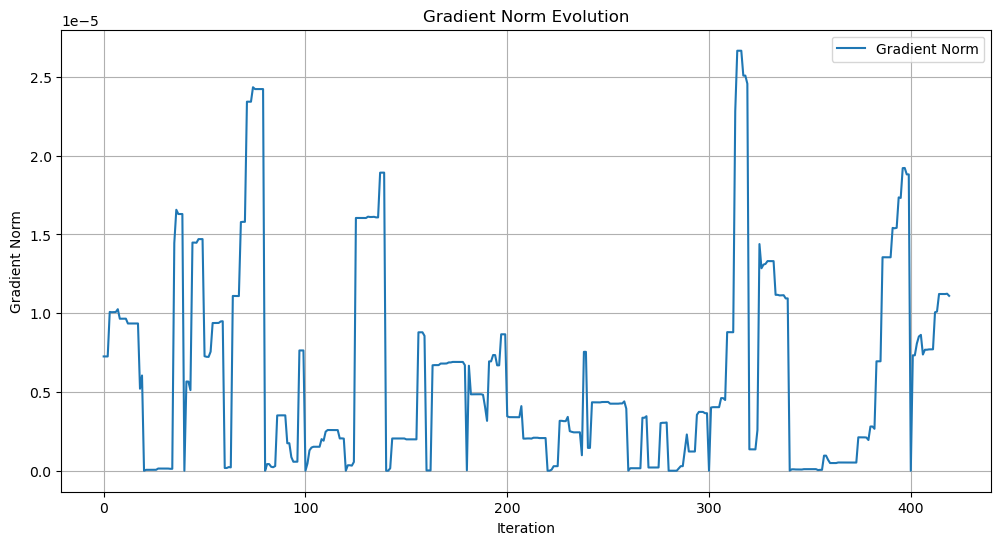


Iteration 40 | Total Loss 0.00001143440204032231
Updated Parameters:
M2: 12.057225227355957
D2: 10.348525047302246


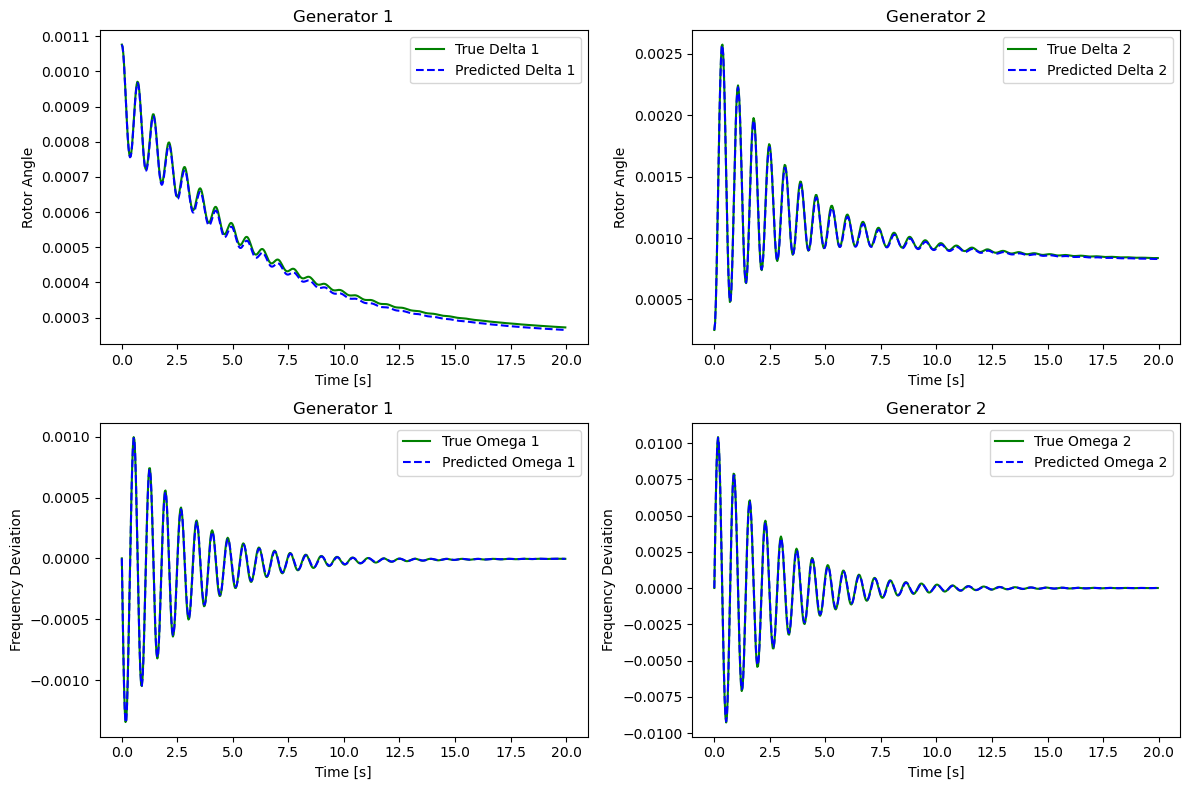

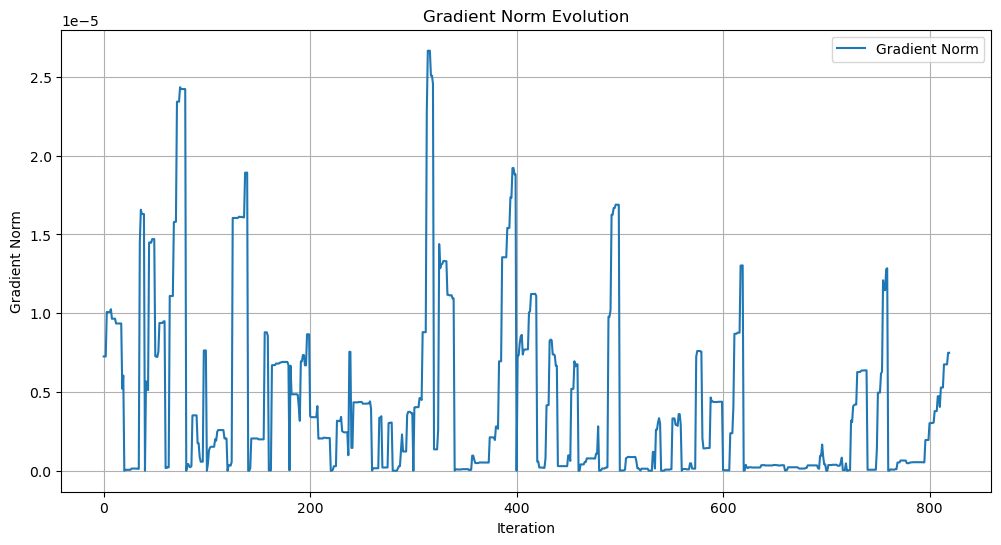

Stopping at iteration 55 as the norm of the gradients is below the threshold: 1e-13
Loss: 0.00000000000004792963
M2_G: 12.00978183746337890625
D2_G: 10.22974777221679687500
V2_G: 2.00000000000000000000
B_G: -0.58307057619094848633
G_G: -0.00339982821606099606
Pmech2_G: 0.47893619537353515625

Iteration 55 | Total Loss 0.00000299955922855588
Updated Parameters:
M2: 12.009781837463379
D2: 10.229747772216797


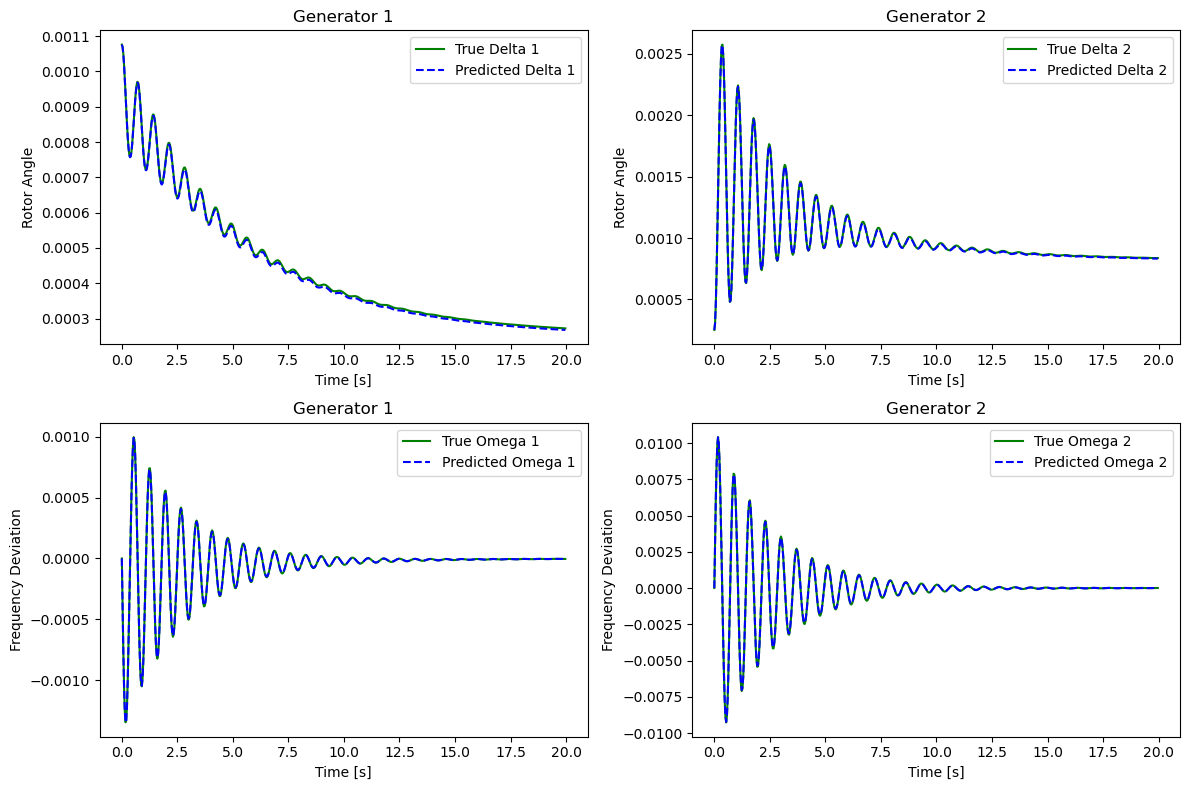

In [12]:
#Training loop - PC - MD
Delta = 1.05 #Porcentual deviation from real value
#TargetPercent = 0.01
Treshold = 1e-15 #1e-11 for all cases, 1e-13 for M2, D2
M1_G = M1
D1_G = D1
M2_G = Delta*M2
#M2_G = torch.randint(-Delta, Delta, (1,1))/100 * M2 + M2
D2_G = Delta*D2
#D2_G = torch.randint(-Delta, Delta, (1,1))/100 * D2 + D2
V1_G = v1star
V2_G = v2star
#V2_G = Delta*v2star
#V2_G = torch.randint(-Delta, Delta, (1,1))/100 * v2star + v2star
B_G = Bred
#B_G = Delta*Bred
#B_G = torch.randint(-Delta, Delta, (1,1))/100 * Bred + Bred
G_G = Gred
#G_G = Delta*Gred
#G_G = torch.randint(-Delta, Delta, (1,1))/100 * Gred + Gred
Pmech1_G = Pmech1star
Pmech2_G = Pmech2star
#Pmech2_G = Delta*Pmech2star
#Pmech2_G = torch.randint(-Delta, Delta, (1,1))/100 * Pmech2star + Pmech2star

parameters_correct = [M1,D1,M2,D2,v1star,v2star,Bred,Gred,Pmech1star,Pmech2star]
parameters_data = []


csv_file_path = "C:/Users/LEGION/Documents/GitHub/torchdiffeq/Ejemplos/MD/Data_Win.csv"
plot_save_path = "C:/Users/LEGION/Documents/GitHub/torchdiffeq/Ejemplos/MD/Initial_Win.png"

os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)


#def percent_deviation(current_value, target_value):
#     return abs(current_value - target_value) / target_value * 100 #Relative Estimation Error

print(f"M1: {M1.item()}", f"M1_G: {M1_G.item()}")
print(f"D1: {D1.item()}", f"D1_G: {D1_G.item()}")
print(f"M2: {M2.item()}", f"M2_G: {M2_G.item()}")
print(f"D2: {D2.item()}", f"D2_G: {D2_G.item()}")
print(f"V1: {v1star.item()}", f"V1_G: {V1_G.item()}")
print(f"V2: {v2star.item()}", f"V2_G: {V2_G.item()}")
print(f"Bred: {Bred.item()}", f"B_G: {B_G.item()}")
print(f"Gred: {Gred.item()}", f"G_G: {G_G.item()}")
print(f"Pmech1: {Pmech1star.item()}", f"Pmech1_G: {Pmech1_G.item()}")
print(f"Pmech2: {Pmech2star.item()}", f"Pmech2_G: {Pmech2_G.item()}")

func = NeuralODE(M1_G, D1_G, M2_G, D2_G, V1_G, V2_G, B_G, G_G, Pmech1_G, Pmech2_G).to(device)
normal_lr = 0.001
special_lr = 0.0001
special_param = [func.Pmech2]
other_param = [param for name, param in func.named_parameters() if param not in special_param]
param_groups = [{'params': other_param, 'lr': normal_lr}, {'params': special_param, 'lr': special_lr}]
optimizer = torch.optim.RMSprop(param_groups) #RMSprop
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 100, gamma=0.5, verbose=False)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, epochs=1000, steps_per_epoch=20)
end = time.time()
#time_meter = RunningAverageMeter(0.97)
#loss_meter = RunningAverageMeter(0.97)
ii = 0

with torch.no_grad():
    print('Initial Parameters:')
    for name, param in func.named_parameters():
        print(f"{name}: {param.data}")
    initial_pred = odeint(func,x0,t).to(device)
    initial_true = true_x.to(device)
    visualize(initial_true, initial_pred, func, 0, plot_save_path)

grad_norm_values = []
start_time = time.time()

for itr in range(0, niters):
    grad_norm = 0
    optimizer.zero_grad()
    s, batch_x0, batch_t, batch_x = get_batch()

    for batch_n in range(0,batch_size):
        low = int(s[batch_n])
        high = low + batch_time
        pred_x = odeint(func, batch_x0[batch_n], batch_t, method = method).to(device)
        #print(batch_n+1)
        #loss = torch.mean((pred_x - batch_x[:,batch_n,:,:])**2) #loss using all states.
        loss = torch.mean((pred_x[:,0:2,0] - batch_x[:,batch_n,0:2,0])**2) #loss using only delta1 and omega1.
        loss.backward() #Calculate the dloss/dparameters
        optimizer.step() #Update value of parameters

        with torch.no_grad():
            for name, param in func.named_parameters():
                if name in ['M2', 'D2', 'V2', 'Pmech2']:
                    param.clamp_(min=0.1)
                
        for param in func.parameters():
            if param.grad is not None:
                grad_norm = param.grad.data.norm(2).item()**2
        grad_norm = math.sqrt(grad_norm)
        grad_norm_values.append(grad_norm)

        current_parameters = [param.item() for name, param in func.named_parameters()]
        iteration_time = time.time() - start_time
        parameters_data.append([itr] + current_parameters + [loss.item(), iteration_time, grad_norm])

    if itr % test_freq == 0:
        with torch.no_grad():
            pred_x = odeint(func, x0, t).to(device)
            #loss = torch.mean((func.dydt -  real_dynamics.dxdt)**2)
            #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
            loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
            print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
            print('Updated Parameters:')
            for name, param in func.named_parameters():
                print(f"{name}: {param.data}")
            plot_save_path = f'C:/Users/LEGION/Documents/GitHub/torchdiffeq/Ejemplos/MD/Iteration_{itr}_Win.png'
            visualize(true_x, pred_x, func, ii, plot_save_path)
            
            with open(csv_file_path, 'a', newline='') as csvfile:
                writer = csv.writer(csvfile)
                if itr == 0:
                    header = ['Iteration'] + [name for name, _ in func.named_parameters()] + ['Loss', 'Time', 'Gradient Norm']
                    writer.writerow(header)
                writer.writerows(parameters_data)
                parameters_data = []
            ii += 1

            plt.figure(figsize=(12, 6))
            plt.plot(grad_norm_values, label= 'Gradient Norm')
            plt.xlabel('Iteration')
            plt.ylabel('Gradient Norm')
            plt.title('Gradient Norm Evolution')
            plt.legend()
            plt.grid(True)
            plt.show()

    scheduler.step()
    end = time.time()

    #if grad_norm <= Treshold:
    if loss <= Treshold:
         print(f'Stopping at iteration {itr} as the norm of the gradients is below the threshold: {Treshold}')
         print(f'Loss: {loss.item():.20f}')
         print(f'M2_G: {func.M2.item():.20f}')
         print(f'D2_G: {func.D2.item():.20f}')
         print(f'V2_G: {func.V2.item():.20f}')
         print(f'B_G: {func.B.item():.20f}')
         print(f'G_G: {func.G.item():.20f}')
         print(f'Pmech2_G: {func.Pmech2.item():.20f}')

         with torch.no_grad():
             pred_x = odeint(func, x0, t).to(device)
             #loss = torch.mean((pred_x - true_x)**2) #Loss using all states.
             loss = torch.mean((pred_x[:,0:2,0] - true_x[:,0:2,0])**2) #Loss using only delta1 and omega1.
             print(f'\nIteration {itr:d} | Total Loss {loss.item():.20f}')
             print('Updated Parameters:')
             for name, param in func.named_parameters():
                 print(f"{name}: {param.data}")
             plot_save_path = f'C:/Users/LEGION/Documents/GitHub/torchdiffeq/Ejemplos/MD/Iteration_{itr}_Win.png'
             visualize(true_x, pred_x, func, ii, plot_save_path)
             with open(csv_file_path, 'a', newline='') as csvfile:
                 writer = csv.writer(csvfile)
                 writer.writerows(parameters_data)
         break
